### Sim

In [18]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import List, Tuple

In [19]:
# Constants for allele representation
MAGENTA = 'M'  # Represents the magenta allele
YELLOW = 'Y'   # Represents the yellow allele

# Global counters and data storage
individual_id_counter = 1  # Unique ID counter for individuals, incremented as new individuals are created
genetic_data_records = []  # List to store genetic data for all individuals across generations
chromatid_recombination_records = []  # List to log recombination events for chromatids

In [20]:
from typing import List, Tuple

def build_forward_generations(base_name: str, start_gen: int, end_gen: int) -> List[Tuple[str, str, str]]:
    """
    Create a breeding plan for sequential forward generations,
    starting from start_gen (inclusive) to end_gen (inclusive).
    The first generation (start_gen) is crossed from pure parents 'P_A' and 'P_B'.
    Subsequent generations are crossed from the previous generation.
    """
    plan = []
    for i in range(start_gen, end_gen + 1):
        current = f"{base_name}{i}"
        if i == start_gen:
            # First forward generation crosses pure populations
            plan.append((current, 'P_A', 'P_B'))
        else:
            parent = f"{base_name}{i-1}"
            plan.append((current, parent, parent))
    return plan

def build_backcross_generations(
    base_name: str,
    filial_bases: List[str],
    pure_pop_label: str
) -> List[Tuple[str, str, str]]:
    """
    Build a backcross generation plan given a list of filial generation names.

    Args:
        base_name (str): Prefix for backcross generations (e.g., "BC").
        filial_bases (List[str]): List of filial generation names to backcross (e.g., ['F1', 'F2', 'F3']).
        pure_pop_label (str): Label of the pure population to backcross with (e.g., "P_A" or "P_B").

    Returns:
        List[Tuple[str, str, str]]: List of backcross generation crosses,
            each as (backcross_label, filial_parent, pure_population_parent).
            Example: [('BC1A', 'F1', 'P_A'), ('BC2A', 'F2', 'P_A'), ...]
    """
    plan = []  # Initialize empty list to hold backcross plans

    # Enumerate over filial_bases with index starting at 1
    for i, filial in enumerate(filial_bases, start=1):
        # Construct the backcross generation label, e.g. "BC1A", "BC2A"
        # The last character of pure_pop_label is appended for clarity ("A" or "B")
        backcross_label = f"{base_name}{i}{pure_pop_label[-1]}"

        # Append the tuple (backcross generation label, filial parent, pure population parent)
        plan.append((backcross_label, filial, pure_pop_label))

    return plan  # Return the list of backcross generation plans

In [21]:
class Chromosome:
    def __init__(self, alleles):
        """
        Represent a single chromosome strand as a list of alleles.
        alleles: list of str, e.g. ['M', 'M', 'Y', ...]
        """
        self.alleles = alleles

    def __repr__(self):
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"  # Show first 10 alleles for brevity


class DiploidChromosomePair:
    def __init__(self, chromatid1: Chromosome, chromatid2: Chromosome):
        """
        Represent a pair of homologous chromosomes (diploid pair).
        Each is a Chromosome instance (a single allele strand).
        """
        self.chromatid1 = chromatid1
        self.chromatid2 = chromatid2

    def __repr__(self):
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"


class Individual:
    def __init__(self, num_chromosomes: int, num_loci_per_chromosome: int):
        """
        Represent a diploid individual with a specified number of chromosome pairs,
        each with a fixed number of loci.
        """
        global individual_id_counter
        self.id = individual_id_counter
        individual_id_counter += 1

        self.num_chromosomes = num_chromosomes
        self.num_loci_per_chromosome = num_loci_per_chromosome
        self.diploid_chromosome_pairs: list[DiploidChromosomePair] = []

    def __repr__(self):
        return f"Individual(ID: {self.id}, Chromosomes: {len(self.diploid_chromosome_pairs)})"

    def get_all_numeric_genotypes(self) -> list[int]:
        """
        Convert all diploid genotype data into numeric format per locus:
          - 2 for homozygous MAGENTA (M/M)
          - 0 for homozygous YELLOW (Y/Y)
          - 1 for heterozygous (M/Y or Y/M)
        Returns a flat list for all loci across all chromosome pairs.
        """
        all_numeric = []
        for pair in self.diploid_chromosome_pairs:
            a1 = pair.chromatid1.alleles
            a2 = pair.chromatid2.alleles
            for i in range(self.num_loci_per_chromosome):
                pair_sorted = sorted([a1[i], a2[i]])
                if pair_sorted == [MAGENTA, MAGENTA]:
                    all_numeric.append(2)
                elif pair_sorted == [YELLOW, YELLOW]:
                    all_numeric.append(0)
                else:
                    all_numeric.append(1)
        return all_numeric

    def calculate_hybrid_index(self) -> float:
        """
        Calculate the hybrid index as proportion of MAGENTA alleles across all loci.
        Hybrid index is sum of numeric values / (total alleles * 2), since numeric counts M alleles.
        """
        all_numeric = self.get_all_numeric_genotypes()
        total_alleles = len(all_numeric) * 2  # each numeric genotype counts M alleles; *2 for diploid
        if total_alleles == 0:
            return 0.0
        sum_m = sum(all_numeric)
        return sum_m / total_alleles

    def calculate_heterozygosity(self) -> float:
        """
        Calculate the proportion of heterozygous loci (numeric value == 1).
        """
        all_numeric = self.get_all_numeric_genotypes()
        if len(all_numeric) == 0:
            return 0.0
        return all_numeric.count(1) / len(all_numeric)

    def get_chromatid_block_data(self) -> list[dict]:
        """
        For each chromatid in every diploid chromosome pair,
        analyze runs (blocks) of consecutive identical alleles.

        Returns a list of dicts, each describing one chromatid:
          - individual_id
          - diploid_chr_id (1-based)
          - chromatid_in_pair ('A' or 'B')
          - total_junctions (number of allele block junctions)
          - block_lengths (list of block sizes)
          - block_alleles (list of alleles per block)
        """
        results = []
        for chr_idx, pair in enumerate(self.diploid_chromosome_pairs):
            for chromatid_idx, chromatid in enumerate([pair.chromatid1, pair.chromatid2]):
                junctions, lengths, alleles = self._analyse_single_chromatid(chromatid.alleles)
                results.append({
                    'individual_id': self.id,
                    'diploid_chr_id': chr_idx + 1,
                    'chromatid_in_pair': 'A' if chromatid_idx == 0 else 'B',
                    'total_junctions': junctions,
                    'block_lengths': lengths,
                    'block_alleles': alleles
                })
        return results

    def _analyse_single_chromatid(self, alleles: list[str]) -> tuple[int, list[int], list[str]]:
        """
        Analyse a single chromatid allele sequence to find blocks of consecutive identical alleles.
        Returns:
          - number of junctions (block boundaries)
          - list of block lengths
          - list of block alleles
        """
        if not alleles:
            return 0, [], []

        block_lengths = []
        block_alleles = []

        # groupby groups consecutive identical alleles
        for allele, group in itertools.groupby(alleles):
            group_list = list(group)
            block_lengths.append(len(group_list))
            block_alleles.append(allele)

        junctions = len(block_lengths) - 1 if block_lengths else 0
        return junctions, block_lengths, block_alleles

In [22]:
def record_individual_genome(individual, generation_label):
    """
    Record the genotype of each locus for each chromosome pair in the individual.

    Stores entries in the global list `genetic_data_records` as dictionaries with keys:
      - generation: label of the generation (e.g., 'F2')
      - individual_id: unique ID of the individual
      - diploid_chr_id: chromosome pair number (1-based)
      - locus_position: position index along the chromosome (0-based)
      - genotype: string representing alleles at this locus, e.g. 'M|Y'

    Args:
        individual (Individual): the individual whose genome to record
        generation_label (str): generation label to associate with the record
    """
    for chr_idx, pair in enumerate(individual.diploid_chromosome_pairs):
        for locus_idx in range(individual.num_loci_per_chromosome):
            allele_a = pair.chromatid1.alleles[locus_idx]
            allele_b = pair.chromatid2.alleles[locus_idx]
            genotype_str = f"{allele_a}|{allele_b}"
            genetic_data_records.append({
                'generation': generation_label,
                'individual_id': individual.id,
                'diploid_chr_id': chr_idx + 1,
                'locus_position': locus_idx,
                'genotype': genotype_str
            })

def record_chromatid_recombination(individual, generation_label):
    """
    Record chromatid recombination block data for the individual.

    Obtains recombination/junction data for each chromatid of each chromosome pair
    by calling the individual's `get_chromatid_block_data` method.

    Appends data enriched with generation label to the global list `chromatid_recombination_records`.

    Args:
        individual (Individual): the individual whose recombination data to record
        generation_label (str): generation label to associate with the record
    """
    chromatid_data = individual.get_chromatid_block_data()
    for record in chromatid_data:
        record['generation'] = generation_label
        chromatid_recombination_records.append(record)

In [23]:
def meiosis_with_recombination(diploid_pair, recomb_event_probabilities, recomb_probabilities):
    """
    Simulate meiosis with crossover recombination on a diploid chromosome pair.

    Args:
        diploid_pair (DiploidChromosomePair): Pair of homologous chromatids to recombine.
        recomb_event_probabilities (dict): Probability distribution for number of recombination events (e.g. {0:0.1,1:0.85,2:0.05}).
        recomb_probabilities (list or array): Position-dependent recombination probabilities for loci (length = loci count).

    Returns:
        Chromosome: recombinant chromatid resulting from crossover events.

    Procedure:
    - Randomly select the number of recombination events (0, 1, or 2) based on `recomb_event_probabilities`.
    - If >0 events, select crossover positions along chromosome weighted by `recomb_probabilities`.
    - Construct recombinant chromosome by alternating segments from each parental chromatid between breakpoints.
    """
    loci = diploid_pair.chromatid1.alleles
    loci_len = len(loci)

    # Determine number of recombination events (crossovers) to simulate
    n_events = random.choices(
        population=[0, 1, 2],
        weights=[recomb_event_probabilities.get(i, 0) for i in [0, 1, 2]],
        k=1
    )[0]

    possible_positions = list(range(1, loci_len))  # possible crossover sites (between loci)

    if n_events > 0:
        # Extract recombination probabilities for valid positions (exclude position 0)
        weights = recomb_probabilities[1:loci_len]
        weights_sum = sum(weights)

        if weights_sum == 0:
            # If all weights zero, choose uniformly at random
            chosen_positions = sorted(random.sample(possible_positions, n_events))
        else:
            # Normalise weights to sum to 1 and sample crossover positions accordingly
            norm_weights = [w / weights_sum for w in weights]
            chosen_positions = sorted(random.choices(possible_positions, weights=norm_weights, k=n_events))
    else:
        # No recombination events: no breakpoints
        chosen_positions = []

    parent1 = diploid_pair.chromatid1.alleles
    parent2 = diploid_pair.chromatid2.alleles

    recombinant_alleles = []
    last_pos = 0
    source = 0  # 0 = take from parent1, 1 = take from parent2

    # Include chromosome end as final breakpoint to complete last segment
    breakpoints = chosen_positions + [loci_len]

    # Build recombinant chromosome by alternating segments between parents
    for pos in breakpoints:
        if source == 0:
            recombinant_alleles.extend(parent1[last_pos:pos])
        else:
            recombinant_alleles.extend(parent2[last_pos:pos])
        source = 1 - source  # switch source parent for next segment
        last_pos = pos

    return Chromosome(recombinant_alleles)

In [24]:
def run_genetic_cross(parents_pop_A, parents_pop_B, num_offspring_to_create,
                      generation_label, num_chromosomes_for_offspring,
                      recomb_event_probabilities, recomb_probabilities):
    """
    Simulate a genetic cross between two parental populations to produce offspring.

    Args:
        parents_pop_A (list of Individual): First parental population (e.g., population A).
        parents_pop_B (list of Individual): Second parental population (e.g., population B).
        num_offspring_to_create (int): Number of offspring individuals to generate.
        generation_label (str): Label for the generation (e.g., "F2", "BC1").
        num_chromosomes_for_offspring (int): Number of chromosomes per offspring individual.
        recomb_event_probabilities (dict): Probability distribution for number of recombination events per chromosome.
        recomb_probabilities (list or array): Position-dependent recombination probabilities along chromosomes.

    Returns:
        list of Individual: List of offspring individuals created by crossing parents from populations A and B.

    Procedure:
    - For each offspring to create:
      - Randomly select one parent from each parental population.
      - Create a new Individual with specified chromosome and locus counts.
      - For each chromosome:
        - Simulate meiosis with recombination for each parent's diploid chromosome pair.
        - Combine recombinant chromatids into a diploid chromosome pair for the offspring.
      - Record genotype and recombination data for the offspring.
    """
    offspring = []
    for _ in range(num_offspring_to_create):
        # Randomly select one parent from each parental population
        parent_A = random.choice(parents_pop_A)
        parent_B = random.choice(parents_pop_B)

        # Create new offspring individual
        child = Individual(num_chromosomes_for_offspring, parent_A.num_loci_per_chromosome)

        # For each chromosome, simulate recombination meiosis for each parent and form diploid pairs
        for chr_idx in range(num_chromosomes_for_offspring):
            diploid_pair_A = parent_A.diploid_chromosome_pairs[chr_idx]
            diploid_pair_B = parent_B.diploid_chromosome_pairs[chr_idx]

            # Generate recombinant haploid chromatids from each parent
            haploid_from_A = meiosis_with_recombination(diploid_pair_A, recomb_event_probabilities, recomb_probabilities)
            haploid_from_B = meiosis_with_recombination(diploid_pair_B, recomb_event_probabilities, recomb_probabilities)

            # Form diploid chromosome pair for offspring
            child.diploid_chromosome_pairs.append(DiploidChromosomePair(haploid_from_A, haploid_from_B))

        # Record genetic data for the new offspring
        record_individual_genome(child, generation_label)
        record_chromatid_recombination(child, generation_label)

        # Add offspring to the list
        offspring.append(child)

    return offspring

In [25]:
def create_pure_individual(num_chromosomes: int, num_loci_per_chr: int, allele_type: str) -> Individual:
    """
    Create an individual with pure homozygous chromosomes of a single allele type.

    Args:
        num_chromosomes (int): Number of chromosomes.
        num_loci_per_chr (int): Number of loci per chromosome.
        allele_type (str): Allele to fill all loci with ('M' or 'Y').

    Returns:
        Individual: An individual with all loci homozygous for the specified allele.
    """
    individual = Individual(num_chromosomes, num_loci_per_chr)
    for _ in range(num_chromosomes):
        chr_alleles = [allele_type] * num_loci_per_chr
        chromatid1 = Chromosome(chr_alleles[:])
        chromatid2 = Chromosome(chr_alleles[:])
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))
    return individual


def create_pure_population(num_individuals: int, num_chromosomes: int,
                           num_loci_per_chr: int, allele_type: str) -> list[Individual]:
    """
    Create a population of pure individuals, all homozygous for the same allele.

    Args:
        num_individuals (int): Number of individuals to create.
        num_chromosomes (int): Number of chromosomes per individual.
        num_loci_per_chr (int): Number of loci per chromosome.
        allele_type (str): Allele to fill all loci ('M' or 'Y').

    Returns:
        list[Individual]: List of pure individuals.
    """
    return [create_pure_individual(num_chromosomes, num_loci_per_chr, allele_type) for _ in range(num_individuals)]


def create_F1_population(pure_pop_A: list[Individual], pure_pop_B: list[Individual],
                         recomb_event_probabilities: dict, recomb_probabilities: list) -> list[Individual]:
    """
    Generate an F1 hybrid population by crossing paired individuals from two pure populations.

    Args:
        pure_pop_A (list[Individual]): Pure population A (e.g., all 'M').
        pure_pop_B (list[Individual]): Pure population B (e.g., all 'Y').
        recomb_event_probabilities (dict): Recombination event probabilities.
        recomb_probabilities (list): Position-dependent recombination probabilities.

    Raises:
        ValueError: If populations are not the same size.

    Returns:
        list[Individual]: F1 hybrid individuals resulting from crosses.
    """
    if len(pure_pop_A) != len(pure_pop_B):
        raise ValueError("Pure populations must be same size to create F1 population")

    f1_population = []
    for i in range(len(pure_pop_A)):
        parent_A = pure_pop_A[i]
        parent_B = pure_pop_B[i]

        child = Individual(parent_A.num_chromosomes, parent_A.num_loci_per_chromosome)
        child.diploid_chromosome_pairs = []

        for chr_idx in range(parent_A.num_chromosomes):
            chr_A = parent_A.diploid_chromosome_pairs[chr_idx]
            chr_B = parent_B.diploid_chromosome_pairs[chr_idx]

            haploid_A = meiosis_with_recombination(chr_A, recomb_event_probabilities, recomb_probabilities)
            haploid_B = meiosis_with_recombination(chr_B, recomb_event_probabilities, recomb_probabilities)

            child.diploid_chromosome_pairs.append(DiploidChromosomePair(haploid_A, haploid_B))

        f1_population.append(child)
    return f1_population

In [26]:
def population_stats(pop):
    """
    Calculate summary statistics for a population of Individuals.

    Args:
        pop (list[Individual]): List of individuals in the population.

    Returns:
        dict: Summary stats including mean and std deviation of hybrid index (HI),
              mean and std deviation of heterozygosity (HET), and population size.
    """
    his = [ind.calculate_hybrid_index() for ind in pop]
    hets = [ind.calculate_heterozygosity() for ind in pop]

    return {
        'mean_HI': np.mean(his) if his else 0,
        'std_HI': np.std(his) if his else 0,
        'mean_HET': np.mean(hets) if hets else 0,
        'std_HET': np.std(hets) if hets else 0,
        'count': len(pop)
    }


def simulate_generations(
    initial_pop_A=None,
    initial_pop_B=None,
    generation_plan=None,
    num_offspring_per_cross=2,
    num_chromosomes=2,
    recomb_event_probabilities=None,
    recomb_probabilities=None,
    existing_populations=None,
    verbose=False,
):
    populations = existing_populations if existing_populations is not None else {}

    if initial_pop_A is not None and 'P_A' not in populations:
        populations['P_A'] = initial_pop_A
    if initial_pop_B is not None and 'P_B' not in populations:
        populations['P_B'] = initial_pop_B

    for gen_info in generation_plan:
        if len(gen_info) == 1:
            continue

        gen_name = gen_info[0]
        parents_names = gen_info[1:]

        for p in parents_names:
            if p not in populations:
                raise ValueError(f"Parent population '{p}' not found for generation '{gen_name}'")

        parents_pop_A = populations[parents_names[0]]
        parents_pop_B = populations[parents_names[1]]

        new_pop = run_genetic_cross(
            parents_pop_A,
            parents_pop_B,
            num_offspring_per_cross,
            gen_name,
            num_chromosomes,
            recomb_event_probabilities,
            recomb_probabilities
        )

        populations[gen_name] = new_pop

        if verbose:
            stats = population_stats(new_pop)
            print(f"{gen_name} created from parents {parents_names[0]} and {parents_names[1]} | "
                  f"Count: {len(new_pop)} | Mean HI: {stats['mean_HI']:.3f} (±{stats['std_HI']:.3f}), "
                  f"Mean HET: {stats['mean_HET']:.3f} (±{stats['std_HET']:.3f})")
            print(f"Added {gen_name} to populations. Keys now: {list(populations.keys())}")

    return populations

In [27]:
# Define alleles
MAGENTA = 'M'
YELLOW = 'Y'

# Initialise global record lists
genetic_data_records = []
chromatid_recombination_records = []

# Parameters
num_individuals_per_pure_pop = 8
num_chromosomes = 10
num_loci_per_chr = 100

# Recombination probabilities
recomb_event_probabilities = {0: 0, 1: 1, 2: 0}
recomb_probabilities = [0] + [1]*(num_loci_per_chr - 1)  # uniform recomb across loci

# 1. Create pure populations
pure_pop_A = create_pure_population(num_individuals_per_pure_pop, num_chromosomes, num_loci_per_chr, MAGENTA)
pure_pop_B = create_pure_population(num_individuals_per_pure_pop, num_chromosomes, num_loci_per_chr, YELLOW)

# 2. Record pure populations data
for ind in pure_pop_A:
    record_individual_genome(ind, 'P_A')
    record_chromatid_recombination(ind, 'P_A')

for ind in pure_pop_B:
    record_individual_genome(ind, 'P_B')
    record_chromatid_recombination(ind, 'P_B')

# 3. Create F1 population from pure parents (same size)
f1_pop = create_F1_population(pure_pop_A, pure_pop_B, recomb_event_probabilities, recomb_probabilities)

# 4. Record F1 population data
for ind in f1_pop:
    record_individual_genome(ind, 'F1')
    record_chromatid_recombination(ind, 'F1')

# 5. Print summary statistics
def print_stats(pop, label):
    stats = population_stats(pop)
    print(f"{label} | Count: {stats['count']} | Mean HI: {stats['mean_HI']:.3f} (±{stats['std_HI']:.3f}), Mean HET: {stats['mean_HET']:.3f} (±{stats['std_HET']:.3f})")

print_stats(pure_pop_A, 'Pure Pop A')
print_stats(pure_pop_B, 'Pure Pop B')
print_stats(f1_pop, 'F1 Population')

Pure Pop A | Count: 8 | Mean HI: 1.000 (±0.000), Mean HET: 0.000 (±0.000)
Pure Pop B | Count: 8 | Mean HI: 0.000 (±0.000), Mean HET: 0.000 (±0.000)
F1 Population | Count: 8 | Mean HI: 0.500 (±0.000), Mean HET: 1.000 (±0.000)


In [28]:
def calculate_hi_het(population):
    """
    Calculate the hybrid index (HI) and heterozygosity (HET) for each individual in a population.

    Args:
        population (list of Individual): The population of individuals to analyze.

    Returns:
        tuple: Two lists containing the HI and HET values for each individual, respectively.
    """
    # Calculate hybrid index for each individual by calling their method
    hi_list = [ind.calculate_hybrid_index() for ind in population]

    # Calculate heterozygosity for each individual by calling their method
    het_list = [ind.calculate_heterozygosity() for ind in population]

    # Return the lists of HI and HET values
    return hi_list, het_list

In [39]:
# Generation Setup
forward_plan = build_forward_generations("F", 1, 20) 

# Suppose you have these filial generations from your forward crosses:
filial_generations = ['F1', 'F2', 'F3', 'F4']

# You want to backcross each of these generations to pure population 'P_A'
backcross_plan_A = build_backcross_generations("BC", filial_generations, "P_A")

# You want to backcross each of these generations to pure population 'P_B'
backcross_plan_B = build_backcross_generations("BC", filial_generations, "P_B")

# Combine both plans
combined_BC_plan = backcross_plan_A + backcross_plan_B
print(combined_BC_plan)

[('BC1A', 'F1', 'P_A'), ('BC2A', 'F2', 'P_A'), ('BC3A', 'F3', 'P_A'), ('BC4A', 'F4', 'P_A'), ('BC1B', 'F1', 'P_B'), ('BC2B', 'F2', 'P_B'), ('BC3B', 'F3', 'P_B'), ('BC4B', 'F4', 'P_B')]


In [40]:
# Simulate forward generations first
populations = simulate_generations(
    initial_pop_A=pure_pop_A,
    initial_pop_B=pure_pop_B,
    generation_plan=forward_plan,
    num_offspring_per_cross=8,
    num_chromosomes=10,
    recomb_event_probabilities=recomb_event_probabilities,
    recomb_probabilities=recomb_probabilities,
    verbose=True
)

F1 created from parents P_A and P_B | Count: 8 | Mean HI: 0.500 (±0.000), Mean HET: 1.000 (±0.000)
Added F1 to populations. Keys now: ['P_A', 'P_B', 'F1']
F2 created from parents F1 and F1 | Count: 8 | Mean HI: 0.498 (±0.036), Mean HET: 0.310 (±0.103)
Added F2 to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2']
F3 created from parents F2 and F2 | Count: 8 | Mean HI: 0.479 (±0.042), Mean HET: 0.318 (±0.068)
Added F3 to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3']
F4 created from parents F3 and F3 | Count: 8 | Mean HI: 0.497 (±0.030), Mean HET: 0.324 (±0.061)
Added F4 to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4']
F5 created from parents F4 and F4 | Count: 8 | Mean HI: 0.494 (±0.047), Mean HET: 0.238 (±0.092)
Added F5 to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5']
F6 created from parents F5 and F5 | Count: 8 | Mean HI: 0.478 (±0.027), Mean HET: 0.271 (±0.072)
Added F6 to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F

In [41]:
# Then simulate backcrosses, passing existing populations
populations = simulate_generations(
    generation_plan=combined_BC_plan,
    num_offspring_per_cross=8,
    num_chromosomes=10,
    recomb_event_probabilities=recomb_event_probabilities,
    recomb_probabilities=recomb_probabilities,
    existing_populations=populations,  # Pass forward gens
    verbose=True
)

BC1A created from parents F1 and P_A | Count: 8 | Mean HI: 0.722 (±0.039), Mean HET: 0.556 (±0.077)
Added BC1A to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'BC1A']
BC2A created from parents F2 and P_A | Count: 8 | Mean HI: 0.746 (±0.016), Mean HET: 0.509 (±0.032)
Added BC2A to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'BC1A', 'BC2A']
BC3A created from parents F3 and P_A | Count: 8 | Mean HI: 0.747 (±0.038), Mean HET: 0.506 (±0.076)
Added BC3A to populations. Keys now: ['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'BC1A', 'BC2A', 'BC3A']
BC4A created from parents F4 and P_A | Count: 8 | Mean HI: 0.757 (±0.028), Mean HET: 0.486 (±0.055)
Add

In [42]:
# Initialise a dictionary to store hybrid index and heterozygosity data for all generations
all_generations_data = {}

# Loop through each generation in the populations dictionary
# gen_name is the generation label (e.g., 'P_A', 'F1')
# pop is the list of Individual objects in that generation
for gen_name, pop in populations.items():
    # Calculate hybrid index (hi_list) and heterozygosity (het_list) for all individuals in this population
    hi_list, het_list = calculate_hi_het(pop)
    
    # Store the calculated HI and HET lists in the dictionary under the generation name
    all_generations_data[gen_name] = {'hi': hi_list, 'het': het_list}

# Calculate the mean hybrid index and mean heterozygosity for the pure population A (P_A)
pa_hi = np.mean(all_generations_data['P_A']['hi'])
pa_het = np.mean(all_generations_data['P_A']['het'])

# Calculate the mean hybrid index and mean heterozygosity for the pure population B (P_B)
pb_hi = np.mean(all_generations_data['P_B']['hi'])
pb_het = np.mean(all_generations_data['P_B']['het'])

# Calculate the mean hybrid index and mean heterozygosity for the first hybrid generation (F1)
f1_hi = np.mean(all_generations_data['F1']['hi'])
f1_het = np.mean(all_generations_data['F1']['het'])

### Triangle Plot

In [43]:
def plot_hi_het_triangle_all_generations(all_generations_data, p_a_stats=None, p_b_stats=None, f1_stats=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.set_xlabel("Hybrid Index (proportion M alleles)", fontsize=12)
    ax.set_ylabel("Heterozygosity (proportion heterozygous loci)", fontsize=12)

    generation_styles = {
        'P_A':    {'color': 'magenta', 'alpha': 1.0, 'marker': 'X'},
        'P_B':    {'color': 'cyan',    'alpha': 1.0, 'marker': 'P'},
        'F1':     {'color': 'black',   'alpha': 1.0, 'marker': 'D'},
        'F2':     {'color': 'black',  'alpha': 1.0,  'marker': 'o'},
        'F3':     {'color': 'orange', 'alpha': 1.0,  'marker': 's'},
        'F4':     {'color': 'pink',   'alpha': 1.0,  'marker': 'D'},
        'F5':     {'color': 'green',  'alpha': 1.0,  'marker': '^'},
        'F6':     {'color': 'purple', 'alpha': 1.0,  'marker': 'v'},
        'F7':     {'color': 'purple', 'alpha': 0.25, 'marker': 'v'},
        'F8':     {'color': 'yellow', 'alpha': 1.0,  'marker': '<'},
        'F9':     {'color': 'brown',  'alpha': 1.0,  'marker': '>'},
        'F10':    {'color': 'green',  'alpha': 0.25, 'marker': '^'},
        'BC1':  {'color': 'blue',   'alpha': 0.7,  'marker': 'P'},
        'BC2':  {'color': 'red',    'alpha': 0.7,  'marker': 'X'},
    }

    legend_elements = []

    # Plot P_A, P_B, F1 if provided
    if p_a_stats:
        style = generation_styles['P_A']
        ax.scatter(p_a_stats[0], p_a_stats[1], color=style['color'], alpha=style['alpha'],
                   marker=style['marker'], s=50, label='P_A')
        legend_elements.append(Line2D([0], [0], marker=style['marker'], color='w',
                                      markerfacecolor=style['color'], markersize=10,
                                      alpha=style['alpha'], label='P_A'))

    if p_b_stats:
        style = generation_styles['P_B']
        ax.scatter(p_b_stats[0], p_b_stats[1], color=style['color'], alpha=style['alpha'],
                   marker=style['marker'], s=50, label='P_B')
        legend_elements.append(Line2D([0], [0], marker=style['marker'], color='w',
                                      markerfacecolor=style['color'], markersize=10,
                                      alpha=style['alpha'], label='P_B'))

    if f1_stats:
        style = generation_styles['F1']
        ax.scatter(f1_stats[0], f1_stats[1], color=style['color'], alpha=style['alpha'],
                   marker=style['marker'], s=50, label='F1')
        legend_elements.append(Line2D([0], [0], marker=style['marker'], color='w',
                                      markerfacecolor=style['color'], markersize=10,
                                      alpha=style['alpha'], label='F1'))

    # Plot all other generations
    for gen_name, values in all_generations_data.items():
        style = generation_styles.get(gen_name, {'color': 'grey', 'alpha': 0.5, 'marker': 'o'})
        ax.scatter(values['hi'], values['het'],
                   color=style['color'],
                   alpha=style['alpha'],
                   marker=style['marker'],
                   s=20,
                   label=f'{gen_name} Population')
        legend_elements.append(Line2D([0], [0], marker=style['marker'], color='w',
                                      markerfacecolor=style['color'], markersize=8,
                                      alpha=style['alpha'], label=gen_name))

    # Triangle edges
    triangle_edges = [
        [(0.0, 0.0), (0.5, 1.0)],
        [(0.5, 1.0), (1.0, 0.0)],
        [(0.0, 0.0), (1.0, 0.0)]
    ]
    for (x0, y0), (x1, y1) in triangle_edges:
        ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)

    ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=False, fontsize=9, title="Generations", title_fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.show()

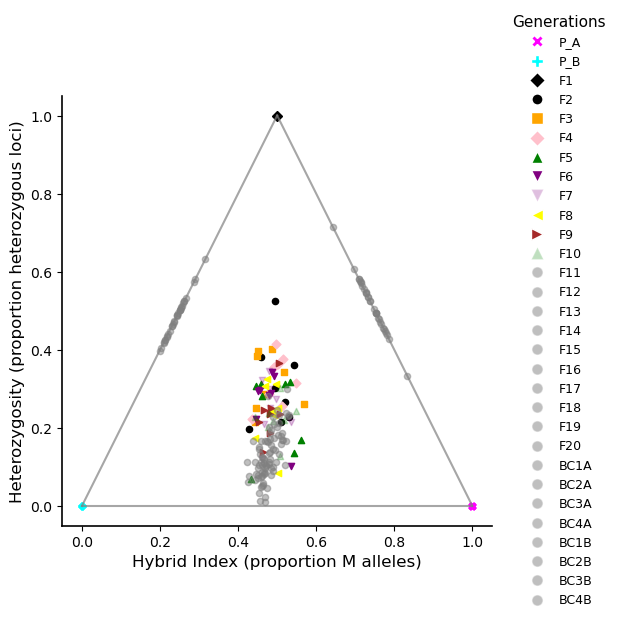

In [44]:
plot_hi_het_triangle_all_generations(
    all_generations_data,
)